# Assembling detector data into images

The X-ray detectors at EuXFEL are made up of a number of small tiles. To assemble an image from the data, or analyse it spatially, we need to know where each piece is located.

This example focuses mainly on LPD data, but the same methods work for all supported detectors.
The example loads data from EuXFEL HDF5 files using [EXtra-data](https://extra-data.readthedocs.io/en/latest/), but you can assemble an image from any stored or streamed data that can give a NumPy array of the correct shape.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py

from extra_data import open_run, stack_detector_data
from extra_geom import LPD_1MGeometry

Load an example run containing LPD data:

In [2]:
run = open_run(proposal=700000, run=7, data='proc')
run.info()

# of trains:    507
Duration:       0:00:50.7
First train ID: 1487289920
Last train ID:  1487290426

13 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 0 : 256 x 256 pixels
  FXE_DET_LPD1M-1/DET/0CH0:xtdf
  30 frames per train, up to 15210 frames total

0 instrument sources (excluding detectors):

0 control sources:



Find the first train with data from all the LPD modules in use:

In [3]:
sel = run.select('*LPD1M-1/DET/*', 'image.data')
for tid, train_data in sel.trains(require_all=True):
    print(f"Found detector data in train {tid}")
    break

for dev in sorted(train_data.keys()):
    print(dev, train_data[dev]['image.data'].shape, sep='\t')

Found detector data in train 1487289920
FXE_DET_LPD1M-1/DET/0CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/11CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/12CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/13CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/14CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/15CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/1CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/2CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/4CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/6CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/7CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/8CH0:xtdf	(30, 256, 256)
FXE_DET_LPD1M-1/DET/9CH0:xtdf	(30, 256, 256)


Extract the detector images into a single Numpy array:

In [4]:
modules_data = stack_detector_data(train_data, 'image.data')
modules_data.shape

(30, 16, 256, 256)

Prepare LPD geometry (see [LPD geometry](lpd_geometry.ipynb) for more about this specific detector):

In [5]:
# From March 18; converted to XFEL standard coordinate directions
quadpos = [(11.4, 299), (-11.5, 8), (254.5, -16), (278.5, 275)]  # mm

geom = LPD_1MGeometry.from_quad_positions(quadpos)

Reassemble and show a detector image using the geometry:

<AxesSubplot:xlabel='pixels', ylabel='pixels'>

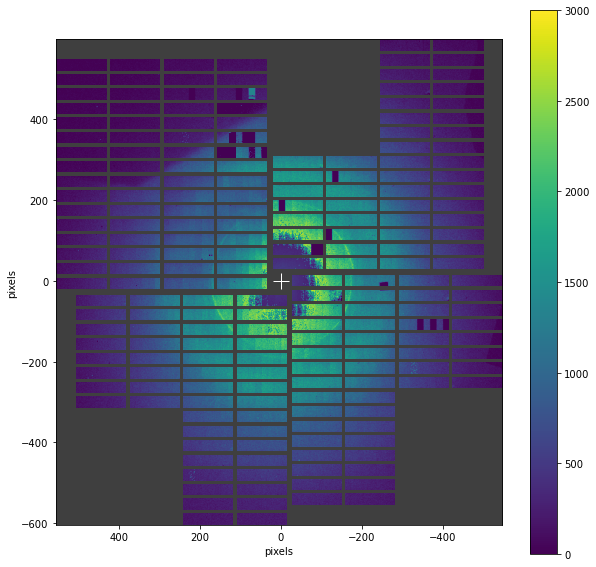

In [6]:
geom.plot_data(modules_data[12], vmin=0, vmax=3000)

To focus in on a specific area, use the matplotlib `Axes` object returned by `plot_data()`.

The coordinates are in pixel units by default, but by passing `plot_data(..., axis_units='m')` you can specify the region in metres instead.

(-200.0, 200.0)

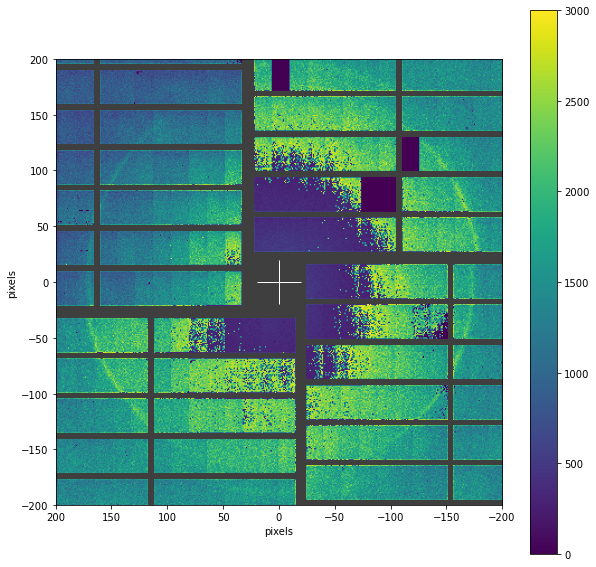

In [7]:
ax = geom.plot_data(modules_data[12], vmin=0, vmax=3000)
ax.set_xlim(200, -200)  # x limits back to front - keep the 'front view' generally used at EuXFEL
ax.set_ylim(-200, 200)

You can also assemble detector data into a numpy array for further analysis.

When assembling floating point data, the areas with no data have the special value *`nan`* to mark them as missing. For integer data, the gaps are filled with 0.

(30, 1202, 1104)


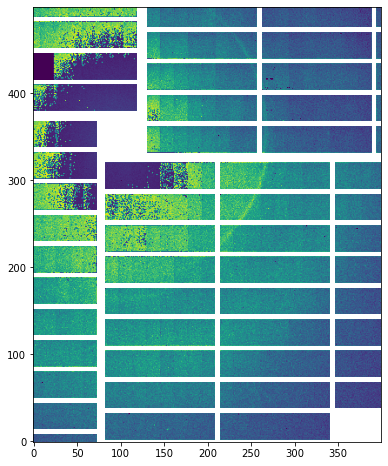

In [8]:
res, centre = geom.position_modules(modules_data)
print(res.shape)
plt.figure(figsize=(8, 8))
plt.imshow(res[12, 250:750, 450:850], vmin=0, vmax=3000, origin='lower')

Let's have a closer at the image from a single module. You can see where it's divided up into tiles:

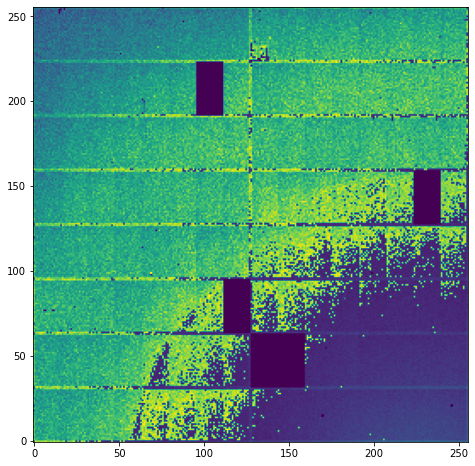

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(modules_data[10, 2], vmin=0, vmax=3000, origin='lower')

The geometry object has a `.split_tiles()` method which cuts the array up into tiles, and puts them in the order that the tiles are numbered.

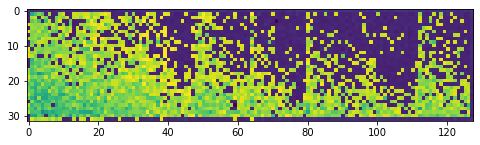

In [10]:
tiles = LPD_1MGeometry.split_tiles(modules_data[10, 2])
plt.figure(figsize=(8, 8))
plt.imshow(tiles[11], vmin=0, vmax=3000)

## AGIPD example

We can do the same with AGIPD data:

In [11]:
agipd_run = open_run(proposal=700000, run=5, data='proc')

tid, train_data = agipd_run.select('*/DET/*', 'image.data').train_from_index(60)
stacked = stack_detector_data(train_data, 'image.data')
stacked_pulse = stacked[10]
stacked_pulse.shape

(16, 512, 128)

Create an [AGIPD geometry object](agipd_geometry.ipynb):

In [12]:
from extra_geom import AGIPD_1MGeometry

agipd_geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

And use it to assemble an image. The geometry object has the same methods as the LPD examples above.

<AxesSubplot:xlabel='pixels', ylabel='pixels'>

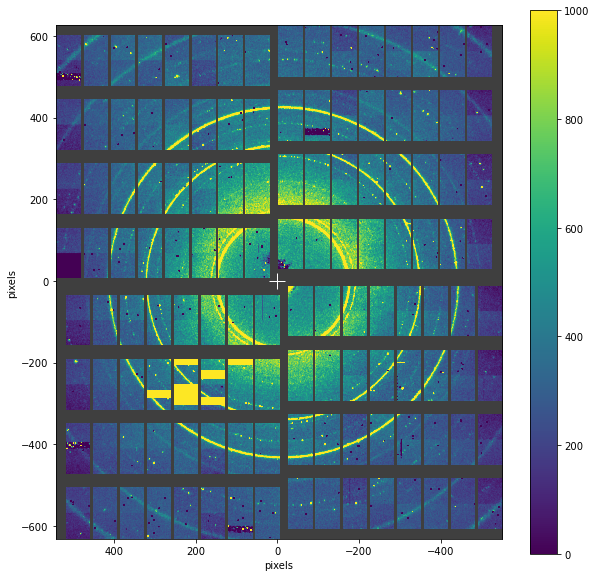

In [13]:
agipd_geom.plot_data(stacked_pulse, vmin=0, vmax=1000)

You can control the plot using keyword arguments for axis and colorbar. For example, to plot two images in the same figure:

Text(0.5, 1.0, 'Average of pulses in one train')

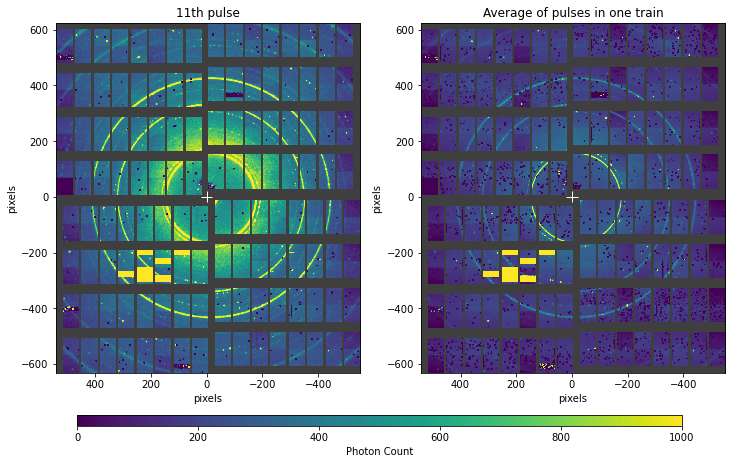

In [14]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 7.5))
ax_cbar = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Create extra axes for the colorbar

# Plot a single pulse in the left axes
agipd_geom.plot_data(stacked_pulse, vmin=0, vmax=1000, ax=ax0, colorbar={
    'cax': ax_cbar,
    'shrink': 0.6,
    'pad': 0.1,
    'orientation': 'horizontal'
})
ax0.set_title('11th pulse')

# Label the colorbar associated with the first image
colorbar = ax0.images[0].colorbar
colorbar.set_label('Photon Count')

# Plot the average over all pulses on the right.
# Disable the colorbar because it's the same scale as the left image.
agipd_geom.plot_data(stacked.mean(axis=0), vmin=0, vmax=1000, ax=ax1, colorbar=False)
ax1.set_title('Average of pulses in one train')